In [1]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as np
import numpy as onp
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
import scft
import functools
import operator
import timeit
import utils
import relaxation as relax
from jax import jit, random
sech = lambda *args,**kwargs : 1 / np.cosh(*args, **kwargs)

# SCFT - 1D

Here we reproduce some basic scft calculations, mainly from Fredrickson's "Equilibrium Theory of Inhomogeneous Polymers" book and the following Ceniceros & Fredrickson paper

[Numerical solution of Polymer Self-Consistent Field Theory](https://epubs.siam.org/doi/epdf/10.1137/030601338)

x  : [0.000, 10.000), dx=1.562e-01 (64 points)
k  : [0.000, 20.735), dk=6.283e-01 (33 points)
f0 : 1.000
f  : 1.000
Ns : 200 A + 0 B = 200 segments 
Q=5.394e-01


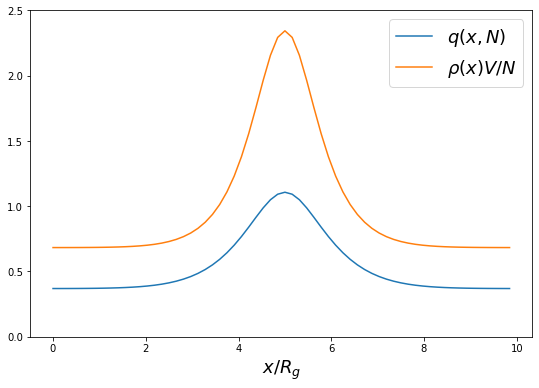

In [2]:
def testsingle(*,L,Num,chi,N):
    
    def W(x):
        """Scaled potential function N w(x), lengths in units of Rg"""
        return 1 - 2*sech(3*(x - L/2)/2)**2
    
    ds       = 1/N
    fft, ifft, x, k, k2     = utils.grid(dim=1, L=L, N=Num)
    init, evolve            = scft.mdeSplit(fft, ifft, k2, ds)
    (diff,diff_c), solution = scft.diblock(init = init, evolve=evolve, chi=chi, f=1.0, N=N)

    diff,diff_c = jit(diff), jit(diff_c)
    solution    = jit(solution)
    
    Wx = W(x)
    Q, (q, _), (phi_a, phi_b), _ = solution(Wx, np.zeros_like(Wx))

    print(f"Q={Q:.3e}")
    fig,ax = plt.subplots(figsize=(9,6))
    ax.plot(x, q[-1,...], label=r'$q(x,N)$')
    ax.plot(x, phi_a, label=r'$\rho(x) V/N$')
    ax.set_xlabel(r'$x/R_g$',fontsize=18)
    ax.legend(fontsize=18)
    ax.set_ylim(0,2.5)
    plt.show()

# ETIP book, Fig.3.14, Chain-end distribution function
testsingle(L=10.0, Num=64, N=200, chi=1.0)

In [3]:
def plotbinary(x,mus,phis,errs):
    fig,axes = plt.subplots(figsize=(18,4), ncols=3)
    ax,bx,cx = axes
    ax.plot(x, phis[1][0], label=r'$\phi_A$')
    ax.plot(x, phis[1][1],ls='--', label=r'$\phi_B$')
    bx.plot(x, mus[1][0], ls='--', label=r'$\mu_+$', color='C2')
    bx.plot(x, mus[1][1], label=r'$\mu_-$', color='C3')
    for xx in [ax,bx]:
        xx.legend(fontsize=14)
        xx.set_xlabel(r'$L/R_g$')
    for err,lbl in zip(errs,['Explicit', 'SIS']):
        cx.plot(err, label=lbl)
    cx.legend(fontsize=14)
    cx.set_ylim(1e-16,1e0)
    cx.set_ylabel(r'Error')
    cx.set_xlabel(r'Iterations')
    cx.semilogy()
    plt.show()
    
    return fig,axes

x  : [0.000, 10.000), dx=3.906e-02 (256 points)
k  : [0.000, 81.053), dk=6.283e-01 (129 points)
Euler time =  3.254 s, error = 3.13e-14
  SIS time =  0.641 s, error = 7.34e-15


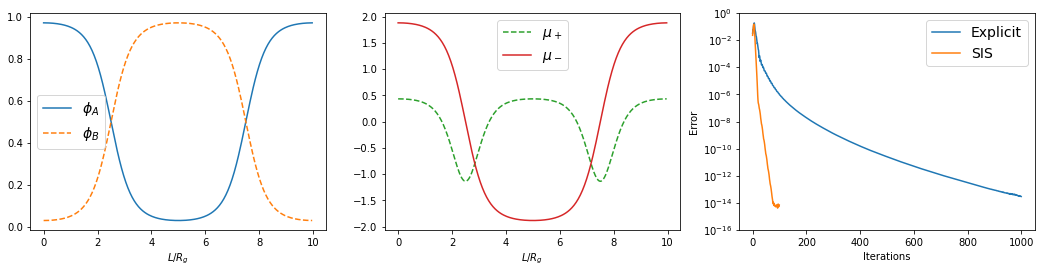

In [4]:
def snapshot(a, b):
    return utils.l1norm(np.abs(a+b))

def testmelt(*, euler, sis, init_guess, L, Num, chi, f, N):
    if isinstance(L, list):
        dim = len(L)
    else:
        dim = 1
    ds                  = 1/N
    fft, ifft, x, k, k2 = utils.grid(dim=dim, L=L, N=Num)
    init, evolve        = scft.mdeSplit(fft, ifft, k2, ds)
    diff, solution      = scft.binarymelt(init=init, evolve=evolve, chi=chi, f=f, N=N)

    saddle_euler = jit(utils.fold(relax.binary_euler(solver=solution, dt=euler['dt'], trj=snapshot))(euler['steps']))
    saddle_sis   = jit(utils.fold(relax.binary_sis(solver=solution, dt=sis['dt'], trj=snapshot, Gs=(scft.single_Debye(k2), 2/chi),
                                                  fft=fft, ifft=ifft))(sis['steps']))
    
    mu0                = init_guess(x, L)
    mu_euler,err_euler = saddle_euler(*mu0)
    mu_sis, err_sis    = saddle_sis(*mu0)
    
    loops  = 1
    print(f"Euler time = {timeit.timeit('saddle_euler(*mu0)', globals=locals(), number=loops)/loops : .3f} s, error = {err_euler[-1]:.2e}")
    print(f"  SIS time = {timeit.timeit('saddle_sis(*mu0)', globals=locals(), number=loops)/loops : .3f} s, error = {err_sis[-1]:.2e}")

    _, _, phi_euler, _ = solution(*utils.binary_pm2ab(*mu_euler))
    _, _, phi_sis, _   = solution(*utils.binary_pm2ab(*mu_sis))
    return x,[mu_euler,mu_sis],[phi_euler,phi_sis],[err_euler, err_sis]

def initmelt(x,L):
    mup = -0.1*np.cos(2*np.pi/L * x)
    mum = 0.1*np.cos(2*np.pi/L* x )
    return mup, mum

# paper, Figs. 7-8, Binary Blend Model
fig, axes = plotbinary(*testmelt(euler = {'dt':1.5, 'steps':1000}, 
                                 sis = {'dt':50.0, 'steps':100}, 
                                 init_guess = initmelt,  L=10.0, Num=256, chi=4.0, f=0.5, N=255))
fig.savefig('./binaryhomopolymer_1d.png', dpi=300, bbox_inches='tight', facecolor='white')

x  : [0.000, 10.000), dx=3.906e-02 (256 points)
k  : [0.000, 81.053), dk=6.283e-01 (129 points)
f0 : 0.500
f  : 0.500
Ns : 128 A + 128 B = 256 segments 
Euler time =  3.319 s, error = 1.07e-11
  SIS time =  1.648 s, error = 2.06e-13


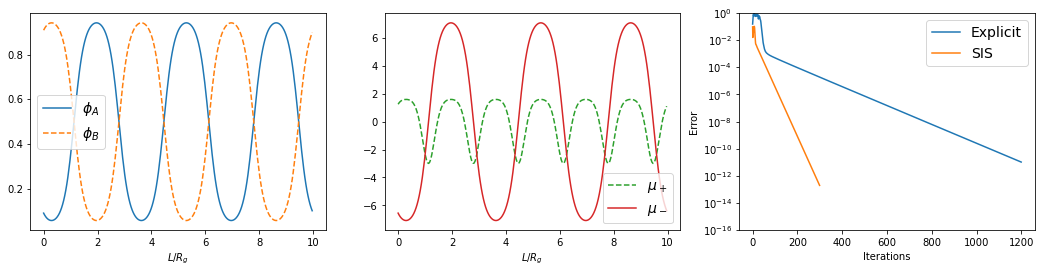

In [5]:
def testdiblock(*, euler, sis, init_guess, L, Num, chi, f, N):
    if isinstance(L, list):
        dim = len(L)
    else:
        dim = 1
    ds               = 1/N

    fft, ifft, x, k, k2 = utils.grid(dim=dim, L=L, N=Num)
    init, evolve        = scft.mdeSplit(fft, ifft, k2, ds)
    diff, solution      = scft.diblock(init=init, evolve=evolve, chi=chi, f=f, N=N)

    saddle_euler = jit(utils.fold(relax.binary_euler(solver=solution, dt=euler['dt'], trj=snapshot))(euler['steps']))
    saddle_sis   = jit(utils.fold(relax.binary_sis(solver=solution, dt=sis['dt'], trj=snapshot,
                                                  Gs=(scft.diblock_Debye(f, k2), 2/chi), fft=fft, ifft=ifft))(sis['steps']))
    
    
    mu0                = init_guess(x)
    mu_euler,err_euler = saddle_euler(*mu0)
    mu_sis, err_sis    = saddle_sis(*mu0)
    
    loops  = 1
    print(f"Euler time = {timeit.timeit('saddle_euler(*mu0)', globals=locals(), number=loops)/loops : .3f} s, error = {err_euler[-1]:.2e}")
    print(f"  SIS time = {timeit.timeit('saddle_sis(*mu0)', globals=locals(), number=loops)/loops : .3f} s, error = {err_sis[-1]:.2e}")

    _, _, phi_euler, _ = solution(*utils.binary_pm2ab(*mu_euler))
    _, _, phi_sis, _ = solution(*utils.binary_pm2ab(*mu_sis))
    return x,[mu_euler,mu_sis],[phi_euler,phi_sis],[err_euler, err_sis]

def initdiblock(x):
    key = random.PRNGKey(1235711)
    mup,mum = random.normal(key, (2,)+x.shape)
    return mup, mum

# paper, Figs. 13-14, Copolymer melt model
fig, ax = plotbinary(*testdiblock(euler = {'dt':4.0, 'steps':1200}, 
                                  sis   = {'dt':500.0,'steps':300}, 
                                  init_guess=initdiblock, chi=16.0, f=0.5, N=256, L=10.0, Num=256))
fig.savefig('./diblockcopolymer_1d.png', dpi=300, bbox_inches='tight', facecolor='white')

# SCFT - 2D

Simple diblock calculation to check that the code works for $d>1$ ...

f0 : 0.700
f  : 0.700
Ns : 49 A + 21 B = 70 segments 
Euler time =  66.323 s, error = 8.90e-04
  SIS time =  31.331 s, error = 5.54e-04


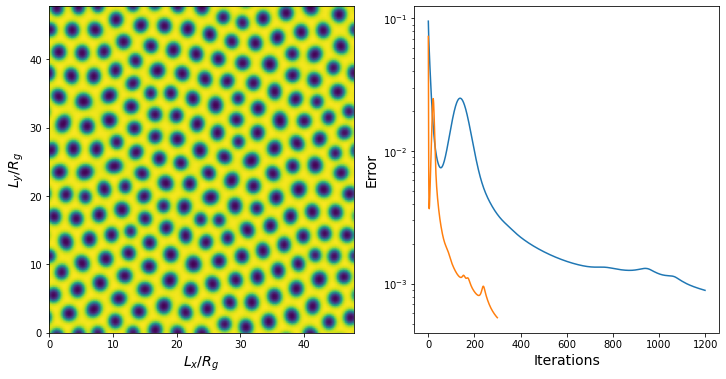

In [8]:
def initdiblockd(x):
    key = random.PRNGKey(1235711)
    mup,mum = random.normal(key, (2,)+x[0].shape)
    return mup, mum
def plotbinary2d(X,mu,phi,err):
    fig,[ax,bx] = plt.subplots(figsize=(12,6), ncols=2)
    ax.pcolormesh(X[0],X[1],phi[1][0], shading='gouraud') # plot \phi_a from sis calculation
    ax.set_xlabel(r'$L_x/R_g$', fontsize=14)
    ax.set_ylabel(r'$L_y/R_g$', fontsize=14)
    bx.plot(err[0])
    bx.plot(err[1])
    bx.set_xlabel(r'Iterations', fontsize=14)
    bx.set_ylabel(r'Error', fontsize=14)
    bx.semilogy()
    plt.show()
    return fig, [ax,bx]
fig, axes= plotbinary2d(*testdiblock(euler={'dt':1.0, 'steps':1200},
                                     sis={'dt':750.0, 'steps':300},
                                     init_guess=initdiblockd, chi=17.0, f=0.7, N=70, L=[48.0, 48.0], Num=[192, 192]))
fig.savefig('./diblockcopolymer_2d.png', dpi=300, bbox_inches='tight', facecolor='white')